In [24]:
%matplotlib inline
import torch
from d2l import torch as d2l

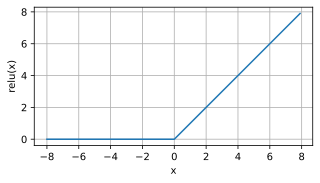

In [25]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))

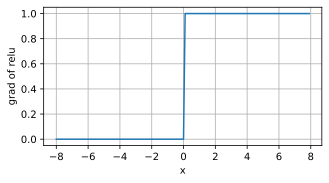

In [26]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))

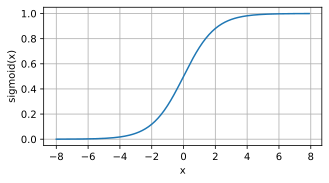

In [27]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))

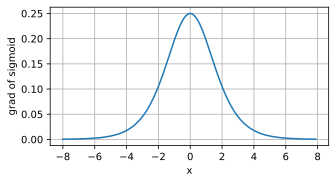

In [28]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))

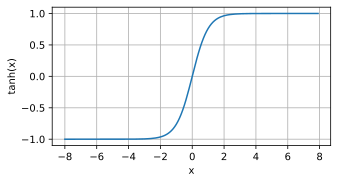

In [29]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))

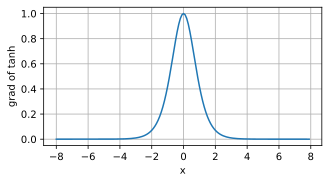

In [30]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))

### Exercises

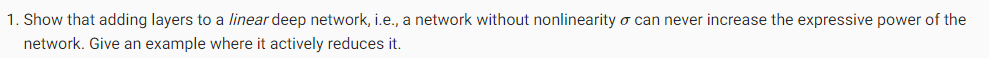

Let's represent a network with $L$ layers. In a purely linear network, each layer $i$ performs a matrix multiplication:$$h_i = W_i h_{i-1}$$(For simplicity, we can ignore the bias $b$ as it doesn't change the linear nature, but the proof holds with it as well).For a 3-layer linear network, the output $\hat{\mathbf{y}}$ for an input $\mathbf{x}$ is:$$\hat{\mathbf{y}} = W_3 (W_2 (W_1 \mathbf{x}))$$By the associative property of matrix multiplication, we can regroup these:$$\hat{\mathbf{y}} = (W_3 W_2 W_1) \mathbf{x}$$We can define a new matrix $W_{combined} = W_3 W_2 W_1$. If $W_1$ is $n \times m$, $W_2$ is $p \times n$, and $W_3$ is $q \times p$, then $W_{combined}$ is simply a single $q \times m$ matrix. Therefore:$$\hat{\mathbf{y}} = W_{combined} \mathbf{x}$$

To make derivation easy, we first rewrite the PReLU function, $f(x) = \max(0, x) + a \cdot \min(0, x)$, into its two distinct linear branches:$$f(x) = \begin{cases} x & \text{if } x > 0 \\ ax & \text{if } x < 0 \end{cases}$$We take the derivative with respect to $x$ for both conditions:For the positive branch ($x > 0$):$$\frac{d}{dx}(x) = 1$$For the negative branch ($x < 0$):$$\frac{d}{dx}(ax) = a$$Combining these results, the derivative of PReLU is:$$f'(x) = \begin{cases} 1 & \text{if } x > 0 \\ a & \text{if } x < 0 \end{cases}$$

$$f'(x) = [1 \cdot \text{sigmoid}(\beta x)] + [x \cdot \beta \cdot \text{sigmoid}(\beta x) \cdot (1 - \text{sigmoid}(\beta x))]$$

In [31]:
import torch
from torch import nn

In [32]:
X = torch.arange(0, 10, 0.1)
W = torch.ones((100, ))
b = torch.randn(size=(1, ))

y = X * W + b

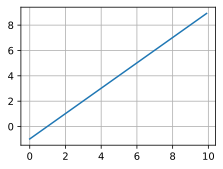

In [33]:
d2l.plot(X, y)

In [34]:
linear = nn.Linear(in_features=1, out_features=3)

h = linear(X.unsqueeze(dim=1))

In [35]:
h.shape

torch.Size([100, 3])

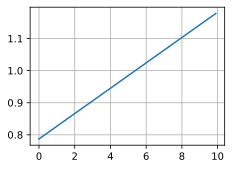

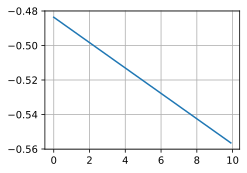

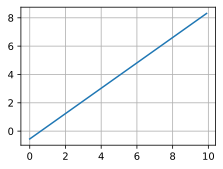

In [36]:
for i in range(h.shape[1]):
  d2l.plot(X, h[:, i].detach().numpy())
  d2l.plt.show()

In [37]:
relu = nn.ReLU()

A = relu(h)

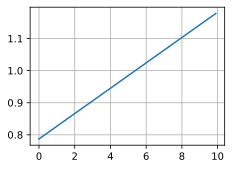

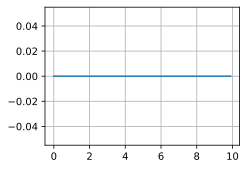

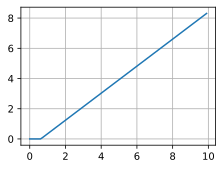

In [38]:
for i in range(A.shape[1]):
  d2l.plot(X, A[:, i].detach().numpy())
  d2l.plt.show()

In [39]:
linear = nn.Linear(in_features=3, out_features=1)
O = linear(A)

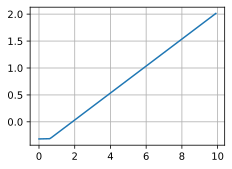

In [40]:
d2l.plot(X, O.squeeze().detach().numpy())

In [ ]:
class VanishingModel(d2l.Module):
    def __init__(self, num_layers=10, num_inputs=5, num_hiddens=10, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        
        layers = []
        # Input Layer
        layers.append(nn.Linear(num_inputs, num_hiddens))
        layers.append(nn.Sigmoid())
        
        # Deep Hidden Layers (The "Vanishing" chain)
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(num_hiddens, num_hiddens))
            layers.append(nn.Sigmoid())
            
        # Output Layer
        layers.append(nn.Linear(num_hiddens, 1))
        self.net = nn.Sequential(*layers)
        
        # Force saturation with large initial weights to make vanishing obvious
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if type(m) == nn.Linear:
            nn.init.normal_(m.weight, std=5)
            nn.init.zeros_(m.bias)

    def forward(self, X):
        return self.net(X)

    def loss(self, y_hat, y):
        return nn.MSELoss()(y_hat, y)

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=self.lr)

class VanishingTrainer(d2l.Trainer):
    def __init__(self, max_epochs, gradient_clip_val=0):
        super().__init__(max_epochs, gradient_clip_val)
        self.grad_history = {}

    def fit_epoch(self):
        self.model.train()
        last_grads = []
        
        for batch in self.train_dataloader:
            loss = self.model.training_step(self.prepare_batch(batch))
            self.optim.zero_grad()
            
            # Perform backpropagation
            loss.backward()
            
            with torch.no_grad():
                if self.gradient_clip_val > 0:
                    self.clip_gradients(self.gradient_clip_val, self.model)
                
                # Capture the gradient norms for every weight layer
                current_batch_grads = [
                    param.grad.norm().item() 
                    for name, param in self.model.named_parameters() 
                    if 'weight' in name and param.grad is not None
                ]
                last_grads = current_batch_grads
                
                self.optim.step()
            self.train_batch_idx += 1
            
        if self.val_dataloader:
            self.model.eval()
            for batch in self.val_dataloader:
                with torch.no_grad():
                    self.model.validation_step(self.prepare_batch(batch))
                self.val_batch_idx += 1
                
        return last_grads

    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = model.configure_optimizers()
        
        # Initialize internal d2l counters
        self.train_batch_idx = 0
        self.val_batch_idx = 0
        
        for i in range(self.max_epochs):
            self.epoch = i
            self.grad_history[f"epoch_{i}"] = self.fit_epoch()

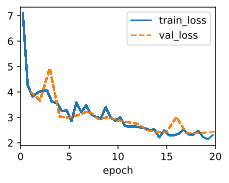

In [55]:
model = VanishingModel(num_layers=10, lr=0.01)
data = d2l.SyntheticRegressionData(w=torch.randn(5), b=torch.tensor(2.0))
trainer = VanishingTrainer(max_epochs=20)
trainer.fit(model, data)